Adam Brannigan 

In [322]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.axes import Axes
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

def draw_clusters(biased_dataset, predictions, cmap='viridis',projection= None):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection=projection)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)
    
    
    
#define method for getting unrated
def get_unrated(user):
    unrated = pd.DataFrame(user.columns[user.isnull().any()])
    unrated.columns=['title']
    return unrated

#define method for getting average for cluster
def get_cluster_avg(unrated):
    cluster_avg = pd.DataFrame(cluster.mean())
    cluster_avg.columns = ['avg rating']
    cluster_avg.index.name='title'
    avg_ratings = pd.merge(unrated,cluster_avg, on='title', how='inner')#.loc[:,0]
    #avg_ratings = pd.concat([unrated,cluster.mean()], axis=1, join='inner').loc[:,0]
    return avg_ratings

# define ethod to return sorted list of movies for user
def show_n_movs(howMany):
    print(avg_ratings.head(howMany).sort_values(by='avg rating',ascending=False))

# Part 1

In [2]:
movies=pd.read_csv('movieinformation/movies.csv')
ratings=pd.read_csv('movieinformation/ratings.csv')


In [3]:
movies.tail(10)

,movieId,title,genres
9115,161830,Body (2015),Drama|Horror|Thriller
9116,161918,Sharknado 4: The 4th Awakens (2016),Action|Adventure|Horror|Sci-Fi
9117,161944,The Last Brickmaker in America (2001),Drama
9118,162376,Stranger Things,Drama
9119,162542,Rustom (2016),Romance|Thriller
9120,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9121,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9122,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary
9123,164977,The Gay Desperado (1936),Comedy
9124,164979,"Women of '69, Unboxed",Documentary


In [4]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [5]:
#How many movies 
movies.title.count()

9125

In [6]:
#How many ratings
ratings.rating.count()

100004

We can see here there are 9125 Movies and 100004 Ratings 

#### Get data for genres Romance and Sci-fi

In [7]:
# create df for romance 
# = movies[(movies.genres.str.contains('Romance'))]
#create df for sci-fi
#cifi = movies[movies.genres.str.contains('Sci-Fi')]
#concatonate the 2 new datatframes
#romsci = pd.concat([romance,scifi])
# drop any dupicates and sort by movie ID 
#romsci = romsci.drop_duplicates().sort_values('movieId')


In [8]:
# get average rating per user for scifi and romance
colnames=['avg_romance_rating','avg_scifi_rating']
genres=['Romance','Sci-Fi']
genre_ratings = get_genre_ratings(ratings,movies,genres,colnames)


In [9]:
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
userId,,
1,3.50,2.40
2,3.59,3.80
3,3.65,3.14
4,4.50,4.26
5,4.08,4.00


In [10]:
genre_ratings.tail()

,avg_romance_rating,avg_scifi_rating
userId,,
667,3.26,4.25
668,5.00,NaN
669,3.25,2.88
670,3.71,3.75
671,3.87,4.04


By Checking the tail of the data we can see that there are 671 users in the data

In [11]:
# drop users that have not rated in the genres from this create X numpy arry
#X = np.array(genre_ratings.dropna())
X = genre_ratings.dropna()

In [12]:
#print(X)

## K-means Cluster

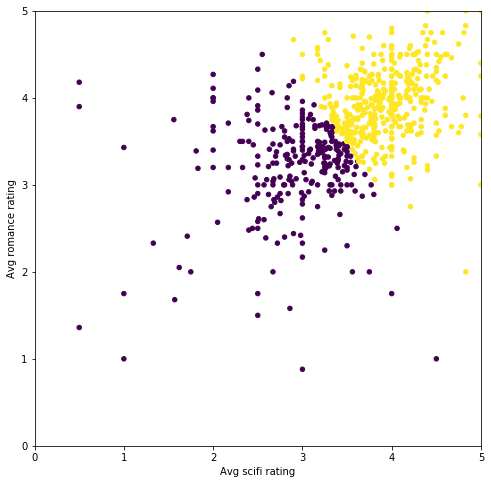

In [13]:
# K-means with 2 clusters 
km = KMeans(n_clusters=2)
y = km.fit_predict(X)
draw_clusters(X,y)


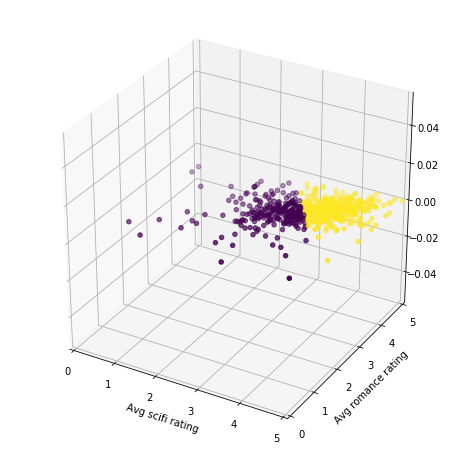

In [14]:
draw_clusters(X,y,projection='3d')

With n = 2 clusters the data seems to be linearly seperable although many data points are quite close together where the seperation would occur this could lead to mis-classifications

### Elbow method to find ideal K

In [15]:
# use elbow method to determine best k
# k means determine k
distortions = []
K = range(2,40)
for k in K:
    km = KMeans(n_clusters=k).fit(X)
    km.fit(X)
    distortions.append(km.inertia_)
    #distortions.append(sum(np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
distortions = np.array(distortions)

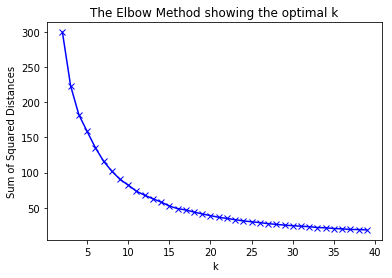

In [16]:
#Plot elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the graph we can see that the probable k value approx between 10 and 12 as anything below is giving deminishing returns. For simplicity of computation in relation to the number of iterations to be performed I will choose 10 as k.

### Redo k-means with new k = 10 value

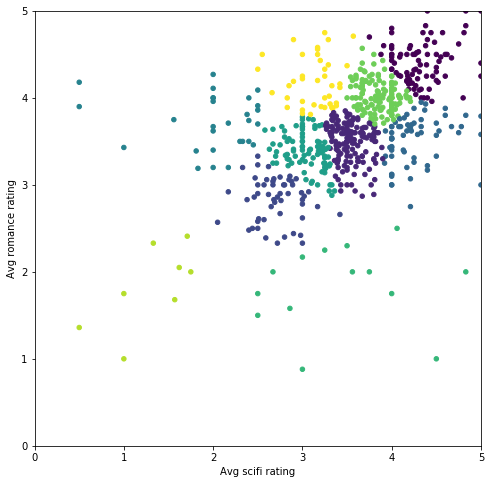

In [17]:
# K-means with 2 clusters 
km = KMeans(n_clusters=10)
y = km.fit_predict(X)
draw_clusters(X,y,)

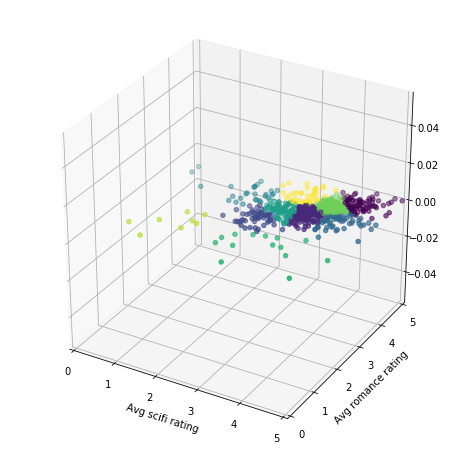

In [18]:
draw_clusters(X,y,projection='3d')

# Part 2 Movie Recommender System

Create a table where each <b>Column</b> is a paticular <b>Movie</b> each <b>Row</b> corresponds to a <b>User</b>

In [27]:
# check movieId in both dataframes
print('movies NO. of movieIds ' + str(movies.movieId.count()))
print('ratings NO. of movieIds ' + str(ratings.movieId.count()))


movies NO. of movieIds 9125
ratings NO. of movieIds 100004


In [61]:
# combine values from movies and raings dataframes
movie_titles = movies.drop(['genres'],axis=1)
#merge on movieID on ratings as it has less no of IDs
merged = pd.merge(movie_titles,ratings, on='movieId',how='right')
merged = merged.pivot_table(index='userId',columns='title',values='rating')
merged

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
# get the top thousand movies
top_1k = get_most_rated_movies(merged, 1000)
top_1k.tail(20)

title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Insomnia (2002),What Lies Beneath (2000),Roman Holiday (1953),"Motorcycle Diaries, The (Diarios de motocicleta) (2004)",Sophie's Choice (1982),Dawn of the Dead (2004),Ocean's Thirteen (2007),Seabiscuit (2003),Easy Rider (1969),Lucky Number Slevin (2006)
651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
652,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN
654,NaN,4.0,NaN,NaN,2.5,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656,3.0,5.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657,5.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658,4.0,3.0,3.0,5.0,5.0,4.0,NaN,NaN,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
659,3.0,NaN,NaN,0.5,4.5,3.0,4.0,2.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
660,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# create sparse matrix
sp_matrix = csr_matrix(pd.SparseDataFrame(top_1k).to_coo())
#print(sp_matrix)

In [76]:
#create model with 20 clusters and get predictions
km = KMeans(n_clusters=20)
predictions = km.fit_predict(sp_matrix)

In [284]:
# combine list of mvies with predictions
clustered = pd.concat([top_1k.reset_index(),pd.DataFrame({'group':predictions})], axis=1)
#reset the index to userid set back form 0 to one as before
clustered.index = np.arange(1, len(clustered)+1)
clustered.index.name='userID'
clustered.head()

,index,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),...,What Lies Beneath (2000),Roman Holiday (1953),"Motorcycle Diaries, The (Diarios de motocicleta) (2004)",Sophie's Choice (1982),Dawn of the Dead (2004),Ocean's Thirteen (2007),Seabiscuit (2003),Easy Rider (1969),Lucky Number Slevin (2006),group
userID,,,,,,,,,,,,,,,,,,,,,
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
2,1,3.0,4.0,NaN,3.0,NaN,4.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,2,5.0,4.5,5.0,3.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
4,3,5.0,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
5,4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


### Check out clusters

In [219]:
# view a certain cluster change cluster number to view different cluster
cluster_number=10
cluster = clustered[clustered.group == cluster_number].drop(
['index','group'], axis=1)
cluster

,level_0,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),...,Insomnia (2002),What Lies Beneath (2000),Roman Holiday (1953),"Motorcycle Diaries, The (Diarios de motocicleta) (2004)",Sophie's Choice (1982),Dawn of the Dead (2004),Ocean's Thirteen (2007),Seabiscuit (2003),Easy Rider (1969),Lucky Number Slevin (2006)
userID,,,,,,,,,,,,,,,,,,,,,
195,194,2.0,3.0,3.0,4.0,5.0,4.0,NaN,NaN,4.0,...,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN
265,264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
342,341,NaN,3.0,5.0,5.0,4.0,NaN,NaN,NaN,5.0,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,357,5.0,5.0,5.0,5.0,5.0,NaN,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387,386,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
466,465,NaN,4.0,5.0,NaN,5.0,4.0,2.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505,504,4.0,3.0,3.5,3.0,4.0,3.0,3.0,NaN,4.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN
529,528,3.0,NaN,4.5,NaN,4.0,NaN,NaN,4.0,5.0,...,NaN,NaN,4.0,NaN,5.0,NaN,NaN,2.5,3.0,NaN
575,574,2.0,NaN,4.0,NaN,5.0,NaN,NaN,3.0,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
# check the average for a movie in the cluster
cluster['Pulp Fiction (1994)'].mean() 

3.7857142857142856

### Check out users

In [315]:
# index is userid
clustered.index[0]
#extract out thier ratings for a cluster
user_number=10
user = clustered[clustered.index == user_number].drop(['index','group'], axis=1)
user

,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Insomnia (2002),What Lies Beneath (2000),Roman Holiday (1953),"Motorcycle Diaries, The (Diarios de motocicleta) (2004)",Sophie's Choice (1982),Dawn of the Dead (2004),Ocean's Thirteen (2007),Seabiscuit (2003),Easy Rider (1969),Lucky Number Slevin (2006)
userID,,,,,,,,,,,,,,,,,,,,,
10,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
# get unrated for user set title
unrated = get_unrated(user)
print(unrated.head())

                                       title
0                        Forrest Gump (1994)
1                        Pulp Fiction (1994)
2           Silence of the Lambs, The (1991)
3  Star Wars: Episode IV - A New Hope (1977)
4                       Jurassic Park (1993)


In [317]:
#Get the average ratings (within that cluster) for all the unrated movies
avg_ratings = get_cluster_avg(unrated)

In [321]:
# Display top 20 descending order
show_n_movs(20)

                                        title  avg rating
19                      Godfather, The (1972)    4.700000
6                     Schindler's List (1993)    4.500000
3   Star Wars: Episode IV - A New Hope (1977)    4.500000
2            Silence of the Lambs, The (1991)    4.285714
10                               Fargo (1996)    4.272727
5                            Toy Story (1995)    4.200000
11                     American Beauty (1999)    4.062500
13                             Aladdin (1992)    4.000000
1                         Pulp Fiction (1994)    3.785714
14                       Fugitive, The (1993)    3.642857
18                      Lion King, The (1994)    3.625000
4                        Jurassic Park (1993)    3.400000
7           Terminator 2: Judgment Day (1991)    3.400000
0                         Forrest Gump (1994)    3.333333
9                   Back to the Future (1985)    3.277778
15                  Dances with Wolves (1990)    3.250000
17            

## Give recommendations
<b>Create a recommender method for the system

In [323]:
#create recommender method 
#clustered = usertable
def give_recommendations(userId,userTable,howMany):
    #find cluster user is in
    cluster_no = userTable.group.loc[userId]
    #print('The userId ' + str(userId)+ ' is in group '+str(cluster_no))
    
    #find all unrated movies for this user
    user = userTable[userTable.index == user_number].drop(['index','group'], axis=1)
    unrated = get_unrated(user)
    
    # get the average ratings for all unrated movies in the cluster
    avg_ratings = get_cluster_avg(unrated)
    
    #return list of top amount of movies
    return show_n_movs(howMany)
    



<b>Now Test the method with userId 195 passing in the table clustered and 20 movies to be recommended

In [327]:
print(give_recommendations(195,clustered,20))

                                        title  avg rating
19                      Godfather, The (1972)    4.700000
6                     Schindler's List (1993)    4.500000
3   Star Wars: Episode IV - A New Hope (1977)    4.500000
2            Silence of the Lambs, The (1991)    4.285714
10                               Fargo (1996)    4.272727
5                            Toy Story (1995)    4.200000
11                     American Beauty (1999)    4.062500
13                             Aladdin (1992)    4.000000
1                         Pulp Fiction (1994)    3.785714
14                       Fugitive, The (1993)    3.642857
18                      Lion King, The (1994)    3.625000
4                        Jurassic Park (1993)    3.400000
7           Terminator 2: Judgment Day (1991)    3.400000
0                         Forrest Gump (1994)    3.333333
9                   Back to the Future (1985)    3.277778
15                  Dances with Wolves (1990)    3.250000
17            